In [19]:
# %% -------------------- XGBoost Model Refinement --------------------

# %% -------------------- Imports and Setup --------------------
import pandas as pd
import numpy as np
import sys
import pathlib
import random
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import joblib

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Setup path
project_root = pathlib.Path().resolve().parent
sys.path.append(str(project_root / 'src'))
import util


In [20]:

# %% -------------------- Load and Preprocess Data --------------------
train_df, test_df = util.load_data('../data/train.csv', '../data/test.csv')

# Separate target
target = 'rainfall'
train_y = train_df[target]
train_X = train_df.drop(columns=[target, 'id'])
test_df_no_id = test_df.drop(columns=['id'])

# Preprocess and align
df_train, df_test = util.preprocess_train_test(train_X, test_df_no_id)
df_test = util.align_columns(df_train, df_test)


Train shape: (2190, 13), Test shape: (730, 12)


In [21]:

# %% -------------------- Class Imbalance Handling --------------------
pos = sum(train_y == 1)
neg = sum(train_y == 0)
scale_pos_weight = neg / pos
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")


Scale Pos Weight: 0.33


In [22]:

# %% -------------------- Optuna Hyperparameter Tuning --------------------

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5.0),
        'scale_pos_weight': scale_pos_weight,
        'random_state': SEED,
        'eval_metric': 'auc'
    }

    model = XGBClassifier(**param)
    scores = cross_val_score(model, df_train, train_y, cv=5, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=10000, show_progress_bar=True)

print("\n===== Best Parameters from Optuna =====")
print(study.best_params)


[I 2025-03-10 20:01:11,146] A new study created in memory with name: no-name-ae3f318e-3aec-4b95-95c7-1e5ab94df4cd


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-03-10 20:01:13,992] Trial 0 finished with value: 0.8841414141414141 and parameters: {'n_estimators': 1436, 'max_depth': 10, 'learning_rate': 0.026975154833351143, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.2904180608409973, 'reg_lambda': 4.330880728874676}. Best is trial 0 with value: 0.8841414141414141.
[I 2025-03-10 20:01:16,676] Trial 1 finished with value: 0.8874242424242424 and parameters: {'n_estimators': 2003, 'max_depth': 8, 'learning_rate': 0.005242693862597309, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.9091248360355031, 'reg_lambda': 0.9170225492671691}. Best is trial 1 with value: 0.8874242424242424.
[I 2025-03-10 20:01:18,926] Trial 2 finished with value: 0.886240179573513 and parameters: {'n_estimators': 1260, 'max_depth': 6, 'learning_rate': 0.013518080333310006, 'subsample': 0.645614570099021, 'colsample_bytree': 0.8

In [23]:

# %% -------------------- Train and Validate with Optimized XGBoost --------------------
X_train, X_val, y_train, y_val = train_test_split(df_train, train_y, test_size=0.2, stratify=train_y, random_state=SEED)

best_xgb_model = XGBClassifier(**study.best_params, random_state=SEED, eval_metric='auc')
best_xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

val_preds = best_xgb_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_preds)
print(f"\nFinal Validation AUC: {val_auc:.4f}")


[0]	validation_0-auc:0.83086
[1]	validation_0-auc:0.85657
[2]	validation_0-auc:0.85623
[3]	validation_0-auc:0.85683
[4]	validation_0-auc:0.85474
[5]	validation_0-auc:0.85734
[6]	validation_0-auc:0.86525
[7]	validation_0-auc:0.87183
[8]	validation_0-auc:0.87724
[9]	validation_0-auc:0.87629
[10]	validation_0-auc:0.87333
[11]	validation_0-auc:0.87240
[12]	validation_0-auc:0.87319
[13]	validation_0-auc:0.87315
[14]	validation_0-auc:0.87125
[15]	validation_0-auc:0.87081
[16]	validation_0-auc:0.86813
[17]	validation_0-auc:0.86773
[18]	validation_0-auc:0.86807
[19]	validation_0-auc:0.86770
[20]	validation_0-auc:0.86880
[21]	validation_0-auc:0.86843
[22]	validation_0-auc:0.86852
[23]	validation_0-auc:0.86780
[24]	validation_0-auc:0.86761
[25]	validation_0-auc:0.86651
[26]	validation_0-auc:0.86632
[27]	validation_0-auc:0.86792
[28]	validation_0-auc:0.86751
[29]	validation_0-auc:0.86857
[30]	validation_0-auc:0.86919
[31]	validation_0-auc:0.86928
[32]	validation_0-auc:0.87107
[33]	validation_0-au

In [24]:

# %% -------------------- Repeated Stratified CV for AUC Stability --------------------
print("\n===== Repeated Stratified K-Fold AUC Evaluation =====")
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
scores = cross_val_score(best_xgb_model, df_train, train_y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Mean AUC: {scores.mean():.4f}, Std: {scores.std():.4f}")

print(f"Interpretation: The model's average AUC is {scores.mean():.4f}, "
      f"indicating good classification ability. "
      f"The standard deviation of {scores.std():.4f} suggests "
      f"{'stable' if scores.std() < 0.02 else 'variable'} performance.")



===== Repeated Stratified K-Fold AUC Evaluation =====
Mean AUC: 0.8930, Std: 0.0229
Interpretation: The model's average AUC is 0.8930, indicating good classification ability. The standard deviation of 0.0229 suggests variable performance.


In [25]:

# %% -------------------- Predict on Test and Create Submission --------------------
test_probs = best_xgb_model.predict_proba(df_test)[:, 1]
util.write_submission(test_df, test_probs, id_column='id', output_path='submission_xgboost_optuna.csv', prediction_column='rainfall')


Submission file written to: submission_xgboost_optuna.csv


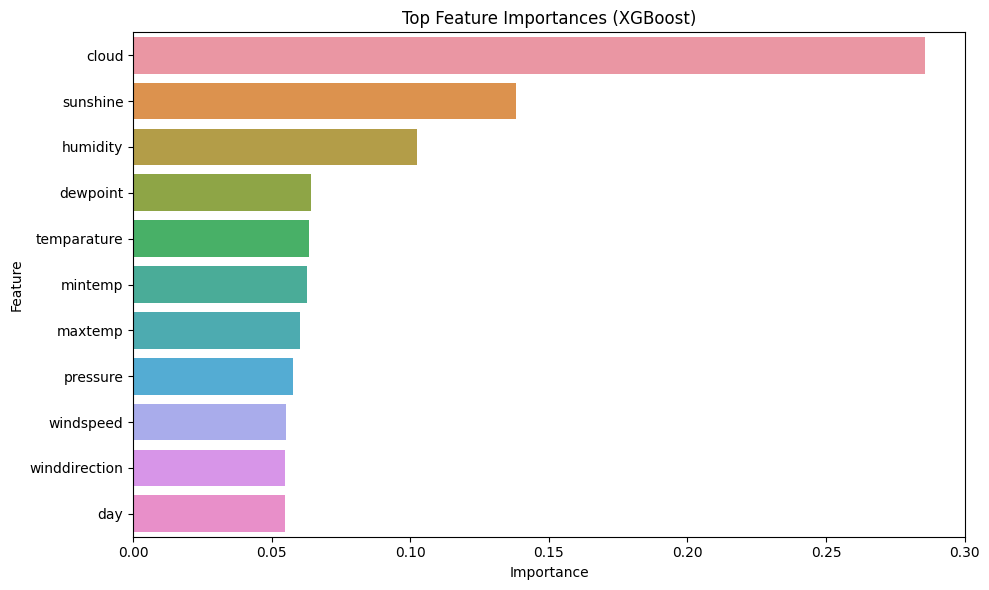

In [26]:

# %% -------------------- Feature Importance Plot --------------------
def plot_feature_importance(model, top_n=20):
    feature_importances = model.feature_importances_
    feature_names = df_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title('Top Feature Importances (XGBoost)')
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_xgb_model)


In [27]:

# %% -------------------- Export XGBoost Model for Stacking --------------------
model_data = {'model': best_xgb_model, 'features': df_train.columns.tolist()}
model_path = 'xgb_optuna_with_features.pkl'
joblib.dump(model_data, model_path)
print(f"XGBoost model and features saved to {model_path}")


XGBoost model and features saved to xgb_optuna_with_features.pkl
